# 載入所需套件

In [1]:
import numpy as np
import pandas as pd  
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
import backtrader as bt
import backtrader.feeds as btfeeds
from datetime import datetime,timedelta

style.use('seaborn')
#設定字體和解決圖像中文顯示問題
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus']=False
register_matplotlib_converters()

%matplotlib inline   

# 設定回測期間和資料報價

In [2]:
# 設定回測期間
start_date=datetime(2018,1,1)
end_date=datetime(2019,12,31)
d1=start_date.strftime('%Y-%m-%d')
d2=end_date.strftime('%Y-%m-%d')
total_day_num=(end_date-start_date).days

# 從Yahoo Finance取得資料報價
data=btfeeds.YahooFinanceData(dataname='^TWII',
                              fromdate=start_date,
                              todate=end_date)

# 定義相關計算函數

In [3]:
def ratio(x,y):
    if y==0:
        return None
    else:
        return round(x/y,2)

def percentage(x,y):
    if y==0:
        return None
    else:
        return '{:.2f}%'.format(x/y*100)
        
# 若獲利交易次數為Z，則調整後毛利=毛利*(Z-根號Z)
def adjust_gross_profit(gross_profit,Z):
    return round(gross_profit*(Z-Z**0.5),2)

# 若交易次數為Z，則調整後毛損=毛損*(Z+根號Z)
def adjust_gross_loss(gross_loss,Z):
    return round(gross_loss*(Z+Z**0.5),2)

def count_positive_series(series):
    return (series[series>0]).count()

def sum_positive_series(series):
    return (series[series>0]).sum()

# 建立回測策略績效系統

## 單商品只做多單策略範例

In [4]:
# MA Cross Strategy
class SmaCross(bt.Strategy):
    # 設定交易參數
    params=dict(ma_period_short=5,
                ma_period_long=10)
    
    
    # 交易記錄
    def log(self,txt,dt=None):
        dt=dt or self.datas[0].datetime.date(0)
        print('{}, {}'.format(dt.isoformat(),txt))
    
    
    def __init__(self):
        # 均線交叉策略
        sma1=bt.ind.SMA(period=self.params.ma_period_short)
        sma2=bt.ind.SMA(period=self.params.ma_period_long)
        self.crossover=bt.ind.CrossOver(sma1,sma2)
        
        # 用收盤價做交易
        self.dataclose=self.datas[0].close
        
        # 初始化交易指令、訊號、買賣紀錄
        self.order=None
        self.singal=None
        self.bns=None
        
        # 初始化平倉累積淨損利、權益數，未平倉權益數
        self.os_cum_pnl=0
        self.os_equity=startcash
        self.oi_equity=startcash
        
        self.trade_list=[]
        self.pnl_list=[]
        self.dd_list=[]
    
    
    # 記錄交易執行情况（可省略，默認不輸出结果）
    def notify_order(self,order):
        # 如果 order 為 Submitted/Accepted，返回空
        if order.status in [order.Submitted,order.Accepted]:
            return
        
        # 如果 order 為 Completed，報告價格结果
        if order.status in [order.Completed]: 
            # 買進
            if order.isbuy():
                # 買進滑價+1點
                order.executed.comm+=slippage_point
                self.oi_equity-=(order.executed.price+order.executed.comm)*mult

                self.log('{}: 價格:{:.2f},   成本:{:.2f},   交易稅和滑價:{:.2f},'\
                         '   現金增減:{:.2f},   權益數:{:.2f}'.format(self.singal,
                                                                     order.executed.price,
                                                                     order.executed.value,
                                                                     order.executed.comm*mult,
                                                                     -(order.executed.price+order.executed.comm)*mult,
                                                                     self.oi_equity))

                self.trade_list.append([self.datas[0].datetime.date(0),
                                        self.singal,
                                        self.bns,
                                        order.executed.price,
                                        order.executed.value,
                                        order.executed.comm*mult,
                                        slippage_point*mult,
                                        (order.executed.comm-slippage_point)*mult,
                                        -(order.executed.price+order.executed.comm)*mult,
                                        self.oi_equity])
            # 賣出
            elif order.issell():
                # 賣出滑價+1點
                order.executed.comm+=slippage_point
                self.oi_equity+=(order.executed.price-order.executed.comm)*mult

                self.log('{}: 價格:{:.2f},   成本:{:.2f},   交易稅和滑價:{:.2f},'\
                         '   現金增減:{:.2f},   權益數:{:.2f}'.format(self.singal,
                                                                     order.executed.price,
                                                                     order.executed.value,
                                                                     order.executed.comm*mult,
                                                                     (order.executed.price-order.executed.comm)*mult,
                                                                     self.oi_equity))

                self.trade_list.append([self.datas[0].datetime.date(0),
                                        self.singal,
                                        self.bns,
                                        order.executed.price,
                                        order.executed.value,
                                        order.executed.comm*mult,
                                        slippage_point*mult,
                                        (order.executed.comm-slippage_point)*mult,
                                        (order.executed.price-order.executed.comm)*mult,
                                        self.oi_equity])
                    
            self.bar_executed=len(self) 

        # 如果 order 為 Canceled/Margin/Rejected，報告交易失敗结果
        elif order.status in [order.Canceled,order.Margin,order.Rejected]:
            self.log('交易失敗')
        
        self.order=None
        
        
    # 記錄交易收益情况（可省略，默認不输出结果）
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        
        # 滑價來回各1點
        trade.pnlcomm-=2*slippage_point
        self.os_cum_pnl+=trade.pnlcomm*mult
        self.os_equity+=trade.pnlcomm*mult
       
        self.log('策略收益: 毛損益:{:.2f},   净損益:{:.2f},   累積淨損益:{:.2f},'\
                 '   交易稅和滑價:{:.2f},   平倉權益數:{:.2f}\n'.format(trade.pnl*mult,
                                                                      trade.pnlcomm*mult,
                                                                      self.os_cum_pnl,
                                                                      (trade.pnl-trade.pnlcomm)*mult,
                                                                      self.os_equity))
        
        self.pnl_list.append([self.datas[0].datetime.date(0),
                              trade.getdataname(),
                              trade.pnl*mult,
                              trade.pnlcomm*mult,
                              self.os_cum_pnl,
                              (trade.pnl-trade.pnlcomm)*mult,
                              2*slippage_point*mult,
                              (trade.pnl-trade.pnlcomm-2*slippage_point)*mult,
                              self.os_equity,
                              trade.barlen,
                              self.stats.drawdown.drawdown[-1]*mult*startcash/100,
                              self.stats.drawdown.maxdrawdown[-1]*mult*startcash/100])
    
    
    def next(self):
        # 檢查是否有指令等待執行 
        if self.order: 
            return
        
        # 檢查是否持倉   
        if self.position.size==0:
            # 5MA往上穿越20MA
            if self.crossover>0:
                # 使用收盤價買進標的
                self.order=self.buy(price=self.dataclose[0],size=1)
                self.singal='Buy'
                self.bns=1
        
        # 5MA往下穿越20MA
        elif self.position.size>0 and self.crossover<0:
            # 使用收盤價賣出標的
            self.order=self.close(price=self.dataclose[0],size=1)
            self.singal='Sell'
            self.bns=-1
        
        self.dd_list.append([self.datas[0].datetime.date(0),
                             self.stats.drawdown.drawdown[-1]*mult*startcash/100,
                             self.stats.drawdown.maxdrawdown[-1]*mult*startcash/100])
          
            
    def stop(self):
        self.log('期初資金: {:.2f},   期末資金: {:.2f},   期間報酬率(%): {:.2f}%'.format(startcash,
                                                                                       self.os_equity,
                                                                                       (self.os_equity/startcash-1)*100))
        
        trade_df=pd.DataFrame(self.trade_list)
        trade_df.columns=['時間','操作','買賣','價格','成本','交易成本','滑價','交易稅','現金增減','權益數']
        trade_df.to_csv('交易明細結果.csv',index=False,encoding='utf_8_sig')
        
        pnl_df=pd.DataFrame(self.pnl_list)
        pnl_df.columns=['時間','標的','毛損益','淨損益','累積淨損益','交易成本','滑價','交易稅','平倉權益數',
                        '平倉交易K棒數','DD','MDD']
        pnl_df.to_csv('損益明細結果.csv',index=False,encoding='utf_8_sig')
        
        DD_df=pd.DataFrame(self.dd_list)
        DD_df.columns=['時間','DD','MDD']
        DD_df.to_csv('DD結果.csv',index=False,encoding='utf_8_sig')       

## 單商品只做空單策略範例

In [5]:
# MA Cross Strategy
class SmaCross(bt.Strategy):
    # 設定交易參數
    params=dict(ma_period_short=5,
                ma_period_long=10)
    
    
    # 交易記錄
    def log(self,txt,dt=None):
        dt=dt or self.datas[0].datetime.date(0)
        print('{}, {}'.format(dt.isoformat(),txt))
    
    
    def __init__(self):
        # 均線交叉策略
        sma1=bt.ind.SMA(period=self.params.ma_period_short)
        sma2=bt.ind.SMA(period=self.params.ma_period_long)
        self.crossover=bt.ind.CrossOver(sma1,sma2)
        
        # 用收盤價做交易
        self.dataclose=self.datas[0].close
        
        # 初始化交易指令、訊號、買賣紀錄
        self.order=None
        self.singal=None
        self.bns=None
        
        # 初始化平倉累積淨損利、權益數，未平倉權益數
        self.os_cum_pnl=0
        self.os_equity=startcash
        self.oi_equity=startcash
        
        self.trade_list=[]
        self.pnl_list=[]
        self.dd_list=[]
    
    
    # 記錄交易執行情况（可省略，默認不輸出结果）
    def notify_order(self,order):
        # 如果 order 為 Submitted/Accepted，返回空
        if order.status in [order.Submitted,order.Accepted]:
            return
        
        # 如果 order 為 Completed，報告價格结果
        if order.status in [order.Completed]: 
            # 買進
            if order.isbuy():
                # 買進滑價+1點
                order.executed.comm+=slippage_point
                self.oi_equity-=(order.executed.price+order.executed.comm)*mult

                self.log('{}: 價格:{:.2f},   成本:{:.2f},   交易稅和滑價:{:.2f},'\
                         '   現金增減:{:.2f},   權益數:{:.2f}'.format(self.singal,
                                                                     order.executed.price,
                                                                     order.executed.value,
                                                                     order.executed.comm*mult,
                                                                     -(order.executed.price+order.executed.comm)*mult,
                                                                     self.oi_equity))

                self.trade_list.append([self.datas[0].datetime.date(0),
                                        self.singal,
                                        self.bns,
                                        order.executed.price,
                                        order.executed.value,
                                        order.executed.comm*mult,
                                        slippage_point*mult,
                                        (order.executed.comm-slippage_point)*mult,
                                        -(order.executed.price+order.executed.comm)*mult,
                                        self.oi_equity])
            # 賣出
            elif order.issell():
                # 賣出滑價+1點
                order.executed.comm+=slippage_point
                self.oi_equity+=(order.executed.price-order.executed.comm)*mult

                self.log('{}: 價格:{:.2f},   成本:{:.2f},   交易稅和滑價:{:.2f},'\
                         '   現金增減:{:.2f},   權益數:{:.2f}'.format(self.singal,
                                                                     order.executed.price,
                                                                     order.executed.value,
                                                                     order.executed.comm*mult,
                                                                     (order.executed.price-order.executed.comm)*mult,
                                                                     self.oi_equity))

                self.trade_list.append([self.datas[0].datetime.date(0),
                                        self.singal,
                                        self.bns,
                                        order.executed.price,
                                        order.executed.value,
                                        order.executed.comm*mult,
                                        slippage_point*mult,
                                        (order.executed.comm-slippage_point)*mult,
                                        (order.executed.price-order.executed.comm)*mult,
                                        self.oi_equity])
                    
            self.bar_executed=len(self) 

        # 如果 order 為 Canceled/Margin/Rejected，報告交易失敗结果
        elif order.status in [order.Canceled,order.Margin,order.Rejected]:
            self.log('交易失敗')
        
        self.order=None
        
        
    # 記錄交易收益情况（可省略，默認不输出结果）
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        
        # 滑價來回各1點
        trade.pnlcomm-=2*slippage_point
        self.os_cum_pnl+=trade.pnlcomm*mult
        self.os_equity+=trade.pnlcomm*mult
       
        self.log('策略收益: 毛損益:{:.2f},   净損益:{:.2f},   累積淨損益:{:.2f},'\
                 '   交易稅和滑價:{:.2f},   平倉權益數:{:.2f}\n'.format(trade.pnl*mult,
                                                                      trade.pnlcomm*mult,
                                                                      self.os_cum_pnl,
                                                                      (trade.pnl-trade.pnlcomm)*mult,
                                                                      self.os_equity))
        
        self.pnl_list.append([self.datas[0].datetime.date(0),
                              trade.getdataname(),
                              trade.pnl*mult,
                              trade.pnlcomm*mult,
                              self.os_cum_pnl,
                              (trade.pnl-trade.pnlcomm)*mult,
                              2*slippage_point*mult,
                              (trade.pnl-trade.pnlcomm-2*slippage_point)*mult,
                              self.os_equity,
                              trade.barlen,
                              self.stats.drawdown.drawdown[-1]*mult*startcash/100,
                              self.stats.drawdown.maxdrawdown[-1]*mult*startcash/100])
    
    
    def next(self):
        # 取得現在日期
        date=self.data.datetime.date()
        
        # 檢查是否有指令等待執行 
        if self.order: 
            return
        
        # 檢查是否持倉   
        if self.position.size==0:
            # 空單進場
            # 5MA往下穿越20MA
            if self.crossover<0:
                # 使用收盤價賣出標的
                self.order=self.sell(price=self.dataclose[0],size=1)
                self.singal='Sellshort'
                self.bns=-1
        
        # 空單出場
        # 5MA往上穿越20MA
        elif self.position.size<0 and (self.crossover>0 or date>=(end_date.date()-timedelta(days=4))):
            # 使用收盤價買進標的
            self.order=self.close(price=self.dataclose[0],size=1)
            self.singal='Buytocover'
            self.bns=1
        
        self.dd_list.append([self.datas[0].datetime.date(0),
                             self.stats.drawdown.drawdown[-1]*mult*startcash/100,
                             self.stats.drawdown.maxdrawdown[-1]*mult*startcash/100])
          
            
    def stop(self):
        self.log('期初資金: {:.2f},   期末資金: {:.2f},   期間報酬率(%): {:.2f}%'.format(startcash,
                                                                                       self.os_equity,
                                                                                       (self.os_equity/startcash-1)*100))
        
        trade_df=pd.DataFrame(self.trade_list)
        trade_df.columns=['時間','操作','買賣','價格','成本','交易成本','滑價','交易稅','現金增減','權益數']
        trade_df.to_csv('交易明細結果.csv',index=False,encoding='utf_8_sig')
        
        pnl_df=pd.DataFrame(self.pnl_list)
        pnl_df.columns=['時間','標的','毛損益','淨損益','累積淨損益','交易成本','滑價','交易稅','平倉權益數',
                        '平倉交易K棒數','DD','MDD']
        pnl_df.to_csv('損益明細結果.csv',index=False,encoding='utf_8_sig')
        
        DD_df=pd.DataFrame(self.dd_list)
        DD_df.columns=['時間','DD','MDD']
        DD_df.to_csv('DD結果.csv',index=False,encoding='utf_8_sig')       

## 單商品多空單策略範例

In [6]:
# MA Cross Strategy
class SmaCross(bt.Strategy):
    # 設定交易參數
    params=dict(ma_period_short=5,
                ma_period_long=10,
                rsi_period=20)
    
    
    # 交易記錄
    def log(self,txt,dt=None):
        dt=dt or self.datas[0].datetime.date(0)
        print('{}, {}'.format(dt.isoformat(),txt))
    
    
    def __init__(self):
        # 用收盤價做交易
        self.dataclose=self.datas[0].close
        
        # 均線交叉策略
        sma1=bt.ind.SMA(period=self.params.ma_period_short)
        sma2=bt.ind.SMA(period=self.params.ma_period_long)
        self.rsi=bt.ind.RSI_SMA(self.data.close,period=self.params.rsi_period)
        self.crossover=bt.ind.CrossOver(sma1,sma2)
        
        # 初始化交易指令、訊號、買賣紀錄
        self.order=None
        self.singal=None
        self.bns=None
        
        # 初始化平倉累積淨損利、權益數，未平倉權益數
        self.os_cum_pnl=0
        self.os_equity=startcash
        self.oi_equity=startcash
        
        self.trade_list=[]
        self.pnl_list=[]
        self.dd_list=[]
    
    
    # 記錄交易執行情况（可省略，默認不輸出结果）
    def notify_order(self,order):
        # 如果 order 為 Submitted/Accepted，返回空
        if order.status in [order.Submitted,order.Accepted]:
            return
        
        # 如果 order 為 Completed，報告價格结果
        if order.status in [order.Completed]: 
            # 買進
            if order.isbuy():
                # 買進滑價+1點
                order.executed.comm+=slippage_point
                self.oi_equity-=(order.executed.price+order.executed.comm)*mult

                self.log('{}: 價格:{:.2f},   成本:{:.2f},   交易稅和滑價:{:.2f},'\
                         '   現金增減:{:.2f},   權益數:{:.2f}'.format(self.singal,
                                                                     order.executed.price,
                                                                     order.executed.value,
                                                                     order.executed.comm*mult,
                                                                     -(order.executed.price+order.executed.comm)*mult,
                                                                     self.oi_equity))

                self.trade_list.append([self.datas[0].datetime.date(0),
                                        self.singal,
                                        self.bns,
                                        order.executed.price,
                                        order.executed.value,
                                        order.executed.comm*mult,
                                        slippage_point*mult,
                                        (order.executed.comm-slippage_point)*mult,
                                        -(order.executed.price+order.executed.comm)*mult,
                                        self.oi_equity])
            # 賣出
            elif order.issell():
                # 賣出滑價+1點
                order.executed.comm+=slippage_point
                self.oi_equity+=(order.executed.price-order.executed.comm)*mult

                self.log('{}: 價格:{:.2f},   成本:{:.2f},   交易稅和滑價:{:.2f},'\
                         '   現金增減:{:.2f},   權益數:{:.2f}'.format(self.singal,
                                                                     order.executed.price,
                                                                     order.executed.value,
                                                                     order.executed.comm*mult,
                                                                     (order.executed.price-order.executed.comm)*mult,
                                                                     self.oi_equity))

                self.trade_list.append([self.datas[0].datetime.date(0),
                                        self.singal,
                                        self.bns,
                                        order.executed.price,
                                        order.executed.value,
                                        order.executed.comm*mult,
                                        slippage_point*mult,
                                        (order.executed.comm-slippage_point)*mult,
                                        (order.executed.price-order.executed.comm)*mult,
                                        self.oi_equity])
                    
            self.bar_executed=len(self) 

        # 如果 order 為 Canceled/Margin/Rejected，報告交易失敗结果
        elif order.status in [order.Canceled,order.Margin,order.Rejected]:
            self.log('交易失敗')
        
        self.order=None
        
    
    # 記錄交易收益情况（可省略，默認不输出结果）
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        
        # 滑價來回各1點
        trade.pnlcomm-=2*slippage_point
        self.os_cum_pnl+=trade.pnlcomm*mult
        self.os_equity+=trade.pnlcomm*mult
       
        self.log('策略收益: 毛損益:{:.2f},   净損益:{:.2f},   累積淨損益:{:.2f},'\
                 '   交易稅和滑價:{:.2f},   平倉權益數:{:.2f}\n'.format(trade.pnl*mult,
                                                                      trade.pnlcomm*mult,
                                                                      self.os_cum_pnl,
                                                                      (trade.pnl-trade.pnlcomm)*mult,
                                                                      self.os_equity))
        self.pnl_list.append([self.datas[0].datetime.date(0),
                              trade.pnl*mult,
                              trade.pnlcomm*mult,
                              self.os_cum_pnl,
                              (trade.pnl-trade.pnlcomm)*mult,
                              2*slippage_point*mult,
                              (trade.pnl-trade.pnlcomm-2*slippage_point)*mult,
                              self.os_equity,
                              trade.barlen,
                              self.stats.drawdown.drawdown[-1]*mult*startcash/100,
                              self.stats.drawdown.maxdrawdown[-1]*mult*startcash/100])
    
    
    def next(self):
        # 取得現在日期
        date=self.data.datetime.date()
        
        # 檢查是否有指令等待執行 
        if self.order: 
            return
        
        # 檢查是否持倉   
        if self.position.size==0:
            # 多單進場
            # 5MA往上穿越20MA
            if self.crossover>0:
                # 使用收盤價買進標的
                self.order=self.buy(price=self.dataclose[0],size=1)
                self.singal='Buy'
                self.bns=1
            
            # 空單進場
            # 5MA往下穿越20MA
            elif self.crossover<0:
                # 使用收盤價賣出標的
                self.order=self.sell(price=self.dataclose[0],size=1)
                self.singal='Sellshort'
                self.bns=-1
        
        # 多單出場
        elif self.position.size>0 and (self.rsi<30 or date>=(end_date.date()-timedelta(days=4))):
            # 使用收盤價賣出標的
            self.order=self.close(price=self.dataclose[0],size=1)
            self.singal='Sell'
            self.bns=-1
            
               
        # 空單出場
        elif self.position.size<0 and (self.rsi>70 or date>=(end_date.date()-timedelta(days=4))):
            # 使用收盤價買進標的
            self.order=self.close(price=self.dataclose[0],size=1)
            self.singal='Buytocover'
            self.bns=1
        
        
        self.dd_list.append([self.datas[0].datetime.date(0),
                             self.stats.drawdown.drawdown[-1]*mult*startcash/100,
                             self.stats.drawdown.maxdrawdown[-1]*mult*startcash/100])
           
    
    def stop(self):
        self.log('期初資金: {:.2f},   期末資金: {:.2f},   期間報酬率(%): {:.2f}%'.format(startcash,
                                                                                       self.os_equity,
                                                                                       (self.os_equity/startcash-1)*100))
        
        trade_df=pd.DataFrame(self.trade_list)
        trade_df.columns=['時間','操作','買賣','價格','成本','交易成本','滑價','交易稅','現金增減','權益數']
        trade_df.to_csv('交易明細結果.csv',index=False,encoding='utf_8_sig')
        
        pnl_df=pd.DataFrame(self.pnl_list)
        pnl_df.columns=['時間','毛損益','淨損益','累積淨損益','交易成本','滑價','交易稅','平倉權益數',
                        '平倉交易K棒數','DD','MDD']
        pnl_df.to_csv('損益明細結果.csv',index=False,encoding='utf_8_sig')
        
        DD_df=pd.DataFrame(self.dd_list)
        DD_df.columns=['時間','DD','MDD']
        DD_df.to_csv('DD結果.csv',index=False,encoding='utf_8_sig')       

# 設定初始資本、契約價值、手續費回測策略績效

In [7]:
# 初始化cerebro
cerebro=bt.Cerebro()
# 將數據傳入回測系統
cerebro.adddata(data)
# 將觀察器加载到回測系統中
cerebro.addobserver(bt.observers.Broker)
cerebro.addobserver(bt.observers.DrawDown)
# 將交易策略加载到回測系統中
cerebro.addstrategy(SmaCross)

# 設置初始資本為 10,000,000
startcash=10000000
cerebro.broker.setcash(startcash) 
# 設置契約價值為 1點 200
mult=200
# 設置滑價點數為 1點
slippage_point=1
# 設置期貨交易稅為 0.002%
cerebro.broker.setcommission(commission=0.00002) 

# 將分析器加载到回測系統中
cerebro.addanalyzer(bt.analyzers.DrawDown,_name='DW')
cerebro.addanalyzer(bt.analyzers.Returns,_name='Returns')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer,_name='TradeAnalyzer')
cerebro.addanalyzer(bt.analyzers.Transactions,_name='Transactions')
cerebro.addanalyzer(bt.analyzers.TimeReturn,_name='TimeReturn')
cerebro.addanalyzer(bt.analyzers.PositionsValue,_name='PositionsValue')

# 開始回測
results=cerebro.run()
strat=results[0]
DW_information=strat.analyzers.DW.get_analysis()['max']
Returns_information=strat.analyzers.Returns.get_analysis()
TradeAnalyzer_information=strat.analyzers.TradeAnalyzer.get_analysis()

2018-02-01, Sellshort: 價格:11139.40,   成本:-11139.40,   交易稅和滑價:244.56,   現金增減:2227635.44,   權益數:12227635.44
2018-03-21, Buytocover: 價格:11037.35,   成本:-11139.40,   交易稅和滑價:244.15,   現金增減:-2207714.15,   權益數:10019921.29
2018-03-21, 策略收益: 毛損益:20410.00,   净損益:19921.29,   累積淨損益:19921.29,   交易稅和滑價:488.71,   平倉權益數:10019921.29

2018-03-26, Sellshort: 價格:10783.57,   成本:-10783.57,   交易稅和滑價:243.13,   現金增減:2156470.87,   權益數:12176392.16
2019-02-12, Buytocover: 價格:10032.08,   成本:-10783.57,   交易稅和滑價:240.13,   現金增減:-2006656.13,   權益數:10169736.03
2019-02-12, 策略收益: 毛損益:150298.00,   净損益:149814.74,   累積淨損益:169736.03,   交易稅和滑價:483.26,   平倉權益數:10169736.03

2019-03-11, Sellshort: 價格:10224.27,   成本:-10224.27,   交易稅和滑價:240.90,   現金增減:2044613.10,   權益數:12214349.13
2019-03-12, Buytocover: 價格:10294.37,   成本:-10224.27,   交易稅和滑價:241.18,   現金增減:-2059115.18,   權益數:10155233.96
2019-03-12, 策略收益: 毛損益:-14020.00,   净損益:-14502.07,   累積淨損益:155233.96,   交易稅和滑價:482.07,   平倉權益數:10155233.96

2019-03-18, Buy: 價格:10455.19,   成本:10455

# 策略結果綜合圖

<IPython.core.display.Javascript object>


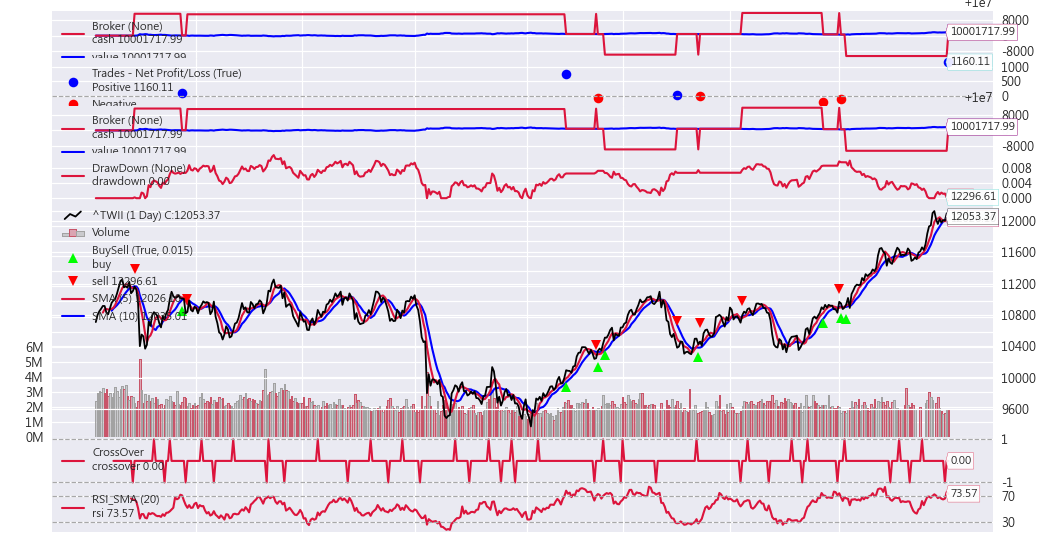

[[<Figure size 432x288 with 8 Axes>]]

In [8]:
cerebro.plot()

# 未平倉每單位部位每日價值變動表

In [9]:
position_value_df=pd.DataFrame(dict(strat.analyzers.PositionsValue.get_analysis()),index=[0]).T
position_value_df.columns=['position value']
position_value_df.tail()

,position value
2019-12-24,11976.38
2019-12-25,12008.13
2019-12-26,12001.01
2019-12-27,12091.59
2019-12-30,0.00


# 未平倉每日報酬率(%)表

In [10]:
daily_return_df=pd.DataFrame(dict(strat.analyzers.TimeReturn.get_analysis()),index=[0]).T
daily_return_df.columns=['daily_return(%)']
daily_return_df['daily_return(%)']=daily_return_df['daily_return(%)']*100*mult
daily_return_df.tail()

,daily_return(%)
2019-12-24,-0.091685
2019-12-25,0.063490
2019-12-26,-0.014238
2019-12-27,0.181131
2019-12-30,0.005955


# 交易明細表

In [11]:
trade_detail_df=pd.DataFrame(data=[e[0] for e in strat.analyzers.Transactions.get_analysis().values()],
                             columns=['amount','price','sid','symbol','value'],
                             index=strat.analyzers.Transactions.get_analysis().keys())
trade_detail_df.index.name='time'
trade_detail_df.head()

,amount,price,sid,symbol,value
time,,,,,
2018-02-01 23:59:59.999989,-1,11139.40,0,^TWII,11139.40
2018-03-21 23:59:59.999989,1,11037.35,0,^TWII,-11037.35
2018-03-26 23:59:59.999989,-1,10783.57,0,^TWII,10783.57
2019-02-12 23:59:59.999989,1,10032.08,0,^TWII,-10032.08
2019-03-11 23:59:59.999989,-1,10224.27,0,^TWII,10224.27


# 讀入結果資料

In [12]:
pnl_df=pd.read_csv('損益明細結果.csv')
pnl_df['時間']=pd.to_datetime(pnl_df['時間'])
pnl_df['年']=pnl_df['時間'].dt.to_period('Y')
pnl_df['年月']=pnl_df['時間'].dt.to_period('M')

trade_df=pd.read_csv('交易明細結果.csv')
trade_df['時間']=pd.to_datetime(trade_df['時間'])
trade_df['年']=trade_df['時間'].dt.to_period('Y')
trade_df['年月']=trade_df['時間'].dt.to_period('M')

In [13]:
pnl_df.head()

,時間,毛損益,淨損益,累積淨損益,交易成本,滑價,交易稅,平倉權益數,平倉交易K棒數,DD,MDD,年,年月
0,2018-03-21,20410.0,19921.29300,19921.29300,488.70700,400,88.70700,1.001992e+07,27,135019.638226,144764.890349,2018,2018-03
1,2019-02-12,150298.0,149814.73740,169736.03040,483.26260,400,83.26260,1.016974e+07,215,109933.483035,226825.876445,2019,2019-02
2,2019-03-12,-14020.0,-14502.07456,155233.95584,482.07456,400,82.07456,1.015523e+07,1,129934.606285,226825.876445,2019,2019-03
3,2019-05-17,10674.0,10190.14500,165424.10084,483.85500,400,83.85500,1.016542e+07,41,122975.547169,226825.876445,2019,2019-05
4,2019-06-05,-402.0,-885.98804,164538.11280,483.98804,400,83.98804,1.016454e+07,1,133446.008274,226825.876445,2019,2019-06


In [14]:
trade_df.head()

,時間,操作,買賣,價格,成本,交易成本,滑價,交易稅,現金增減,權益數,年,年月
0,2018-02-01,Sellshort,-1,11139.40,-11139.40,244.55760,200,44.55760,2.227635e+06,1.222764e+07,2018,2018-02
1,2018-03-21,Buytocover,1,11037.35,-11139.40,244.14940,200,44.14940,-2.207714e+06,1.001992e+07,2018,2018-03
2,2018-03-26,Sellshort,-1,10783.57,-10783.57,243.13428,200,43.13428,2.156471e+06,1.217639e+07,2018,2018-03
3,2019-02-12,Buytocover,1,10032.08,-10783.57,240.12832,200,40.12832,-2.006656e+06,1.016974e+07,2019,2019-02
4,2019-03-11,Sellshort,-1,10224.27,-10224.27,240.89708,200,40.89708,2.044613e+06,1.221435e+07,2019,2019-03


# 多空單交易明細結果

In [15]:
long_trade_query='操作 == "Buy" or 操作 == "Sell"'
long_trade_df=trade_df.query(long_trade_query)
long_trade_df.head()

,時間,操作,買賣,價格,成本,交易成本,滑價,交易稅,現金增減,權益數,年,年月
6,2019-03-18,Buy,1,10455.19,10455.19,241.82076,200,41.82076,-2.091280e+06,8.063954e+06,2019,2019-03
7,2019-05-17,Sell,-1,10508.56,10455.19,242.03424,200,42.03424,2.101470e+06,1.016542e+07,2019,2019-05
8,2019-06-04,Buy,1,10499.51,10499.51,241.99804,200,41.99804,-2.100144e+06,8.065280e+06,2019,2019-06
9,2019-06-05,Sell,-1,10497.50,10499.51,241.99000,200,41.99000,2.099258e+06,1.016454e+07,2019,2019-06
14,2019-10-07,Buy,1,10932.24,10932.24,243.72896,200,43.72896,-2.186692e+06,7.921685e+06,2019,2019-10


In [16]:
short_trade_query='操作 == "Sellshort" or 操作 == "Buytocover"'
short_trade_df=trade_df.query(short_trade_query)
short_trade_df.head()

,時間,操作,買賣,價格,成本,交易成本,滑價,交易稅,現金增減,權益數,年,年月
0,2018-02-01,Sellshort,-1,11139.40,-11139.40,244.55760,200,44.55760,2.227635e+06,1.222764e+07,2018,2018-02
1,2018-03-21,Buytocover,1,11037.35,-11139.40,244.14940,200,44.14940,-2.207714e+06,1.001992e+07,2018,2018-03
2,2018-03-26,Sellshort,-1,10783.57,-10783.57,243.13428,200,43.13428,2.156471e+06,1.217639e+07,2018,2018-03
3,2019-02-12,Buytocover,1,10032.08,-10783.57,240.12832,200,40.12832,-2.006656e+06,1.016974e+07,2019,2019-02
4,2019-03-11,Sellshort,-1,10224.27,-10224.27,240.89708,200,40.89708,2.044613e+06,1.221435e+07,2019,2019-03


# 平倉每日損益表

In [17]:
date_idx=pd.date_range(d1,d2,freq='B')
return_series=pnl_df.set_index('時間').groupby(pd.Grouper(freq='D'))['淨損益'].sum()
return_series=return_series.reindex(date_idx,fill_value=0)
cum_return_series=return_series.cumsum()
cummax_return_series=cum_return_series.cummax()
os_equity_series=startcash+cum_return_series
MDD_series=cummax_return_series-cum_return_series
MDD_ratio_series=MDD_series/os_equity_series*100

return_df=pd.DataFrame({'淨損益':return_series,
                        '累積淨損益':cum_return_series,
                        '累積最大淨損益':cummax_return_series,
                        '平倉權益數':os_equity_series,
                        '最大策略虧損':MDD_series,
                        '最大策略虧損比率(%)':MDD_ratio_series})
return_df.tail()

,淨損益,累積淨損益,累積最大淨損益,平倉權益數,最大策略虧損,最大策略虧損比率(%)
2019-12-25,0.0000,108376.3784,169736.0304,1.010838e+07,61359.652,0.607018
2019-12-26,0.0000,108376.3784,169736.0304,1.010838e+07,61359.652,0.607018
2019-12-27,0.0000,108376.3784,169736.0304,1.010838e+07,61359.652,0.607018
2019-12-30,232021.8918,340398.2702,340398.2702,1.034040e+07,0.000,0.000000
2019-12-31,0.0000,340398.2702,340398.2702,1.034040e+07,0.000,0.000000


# 平倉累積淨損益、累積最大淨損益圖

<IPython.core.display.Javascript object>


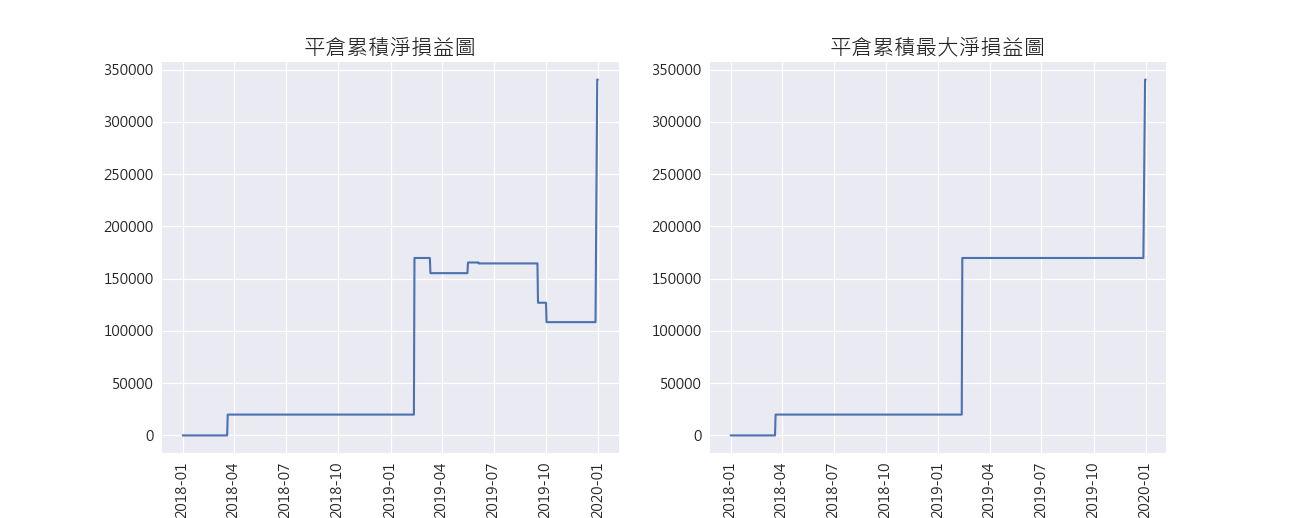

In [18]:
fig,axes=plt.subplots(1,2,figsize=(15,6))
axes[0].plot(cum_return_series)
axes[0].set_title('平倉累積淨損益圖',fontsize=18)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axes[0].tick_params(axis='x',labelsize=12,rotation=90)
axes[0].tick_params(axis='y',labelsize=12)

axes[1].plot(cummax_return_series)
axes[1].set_title('平倉累積最大淨損益圖',fontsize=18)
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axes[1].tick_params(axis='x',labelsize=12,rotation=90)
axes[1].tick_params(axis='y',labelsize=12)

# 平倉權益曲線和績效拉回圖

<IPython.core.display.Javascript object>


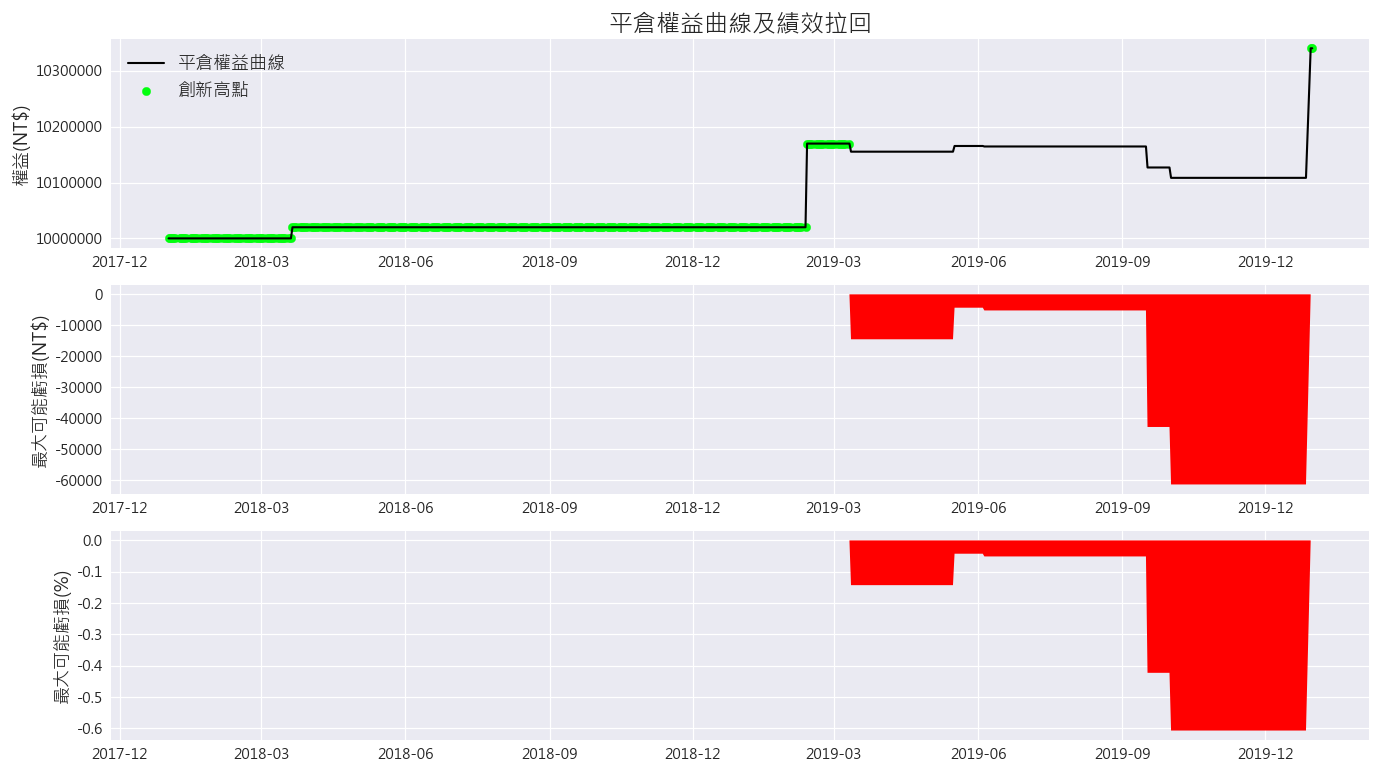

In [19]:
high_index=cum_return_series[cummax_return_series==cum_return_series].index

fig,axes=plt.subplots(3,figsize=(16,9),sharex=True)
axes[0].plot(os_equity_series,label='平倉權益曲線',color='k')
axes[0].scatter(high_index,os_equity_series.loc[high_index],color='#02ff0f',label='創新高點')
axes[0].set_title('平倉權益曲線及績效拉回',fontsize=20)
axes[0].set_ylabel('權益(NT$)',fontsize=15)
axes[0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axes[0].legend(fontsize=15,loc='upper left')
axes[0].tick_params(axis='x',labelsize=12,labelbottom=True)
axes[0].tick_params(axis='y',labelsize=12)

axes[1].fill_between(MDD_series.index,-MDD_series,0,facecolor='r')
axes[1].set_ylabel('最大可能虧損(NT$)',fontsize=15)
axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axes[1].tick_params(axis='x',labelsize=12,labelbottom=True)
axes[1].tick_params(axis='y',labelsize=12)

axes[2].fill_between(MDD_ratio_series.index,-MDD_ratio_series,0,facecolor='r')
axes[2].set_ylabel('最大可能虧損(%)',fontsize=15)
axes[2].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axes[2].tick_params(axis='x',labelsize=12,labelbottom=True)
axes[2].tick_params(axis='y',labelsize=12)

fig.tight_layout()

# 年週期分析表

In [20]:
yearly_pnl=pnl_df.groupby(['年'])['淨損益'].sum()
yearly_pnl_rate=yearly_pnl/startcash*100
# 毛利:獲利交易淨利和
yearly_gross_profit=pnl_df.groupby(['年'])['淨損益'].apply(sum_positive_series)
# 毛損:虧損交易淨損和
yearly_gross_loss=yearly_pnl-yearly_gross_profit

yearly_trade_num=pnl_df.groupby(['年'])['淨損益'].count()*2
yearly_win_trade_num=pnl_df.groupby(['年'])['淨損益'].apply(count_positive_series)*2
yearly_win_rate=(yearly_win_trade_num/yearly_trade_num)*100

yearly_trade_df=pd.DataFrame({'獲利金額':yearly_pnl.apply(lambda x:'{:.2f}'.format(x)),
                              '獲利 (%)':yearly_pnl_rate.apply(lambda x:'{:.2f}%'.format(x)),
                              '毛利':yearly_gross_profit.apply(lambda x:'{:.2f}'.format(x)),
                              '毛損':yearly_gross_loss.apply(lambda x:'{:.2f}'.format(x)),
                              '交易次數':yearly_trade_num,
                              '勝率 (%)':yearly_win_rate.apply(lambda x:'{:.2f}%'.format(x))})
yearly_trade_df

,獲利金額,獲利 (%),毛利,毛損,交易次數,勝率 (%)
年,,,,,,
2018,19921.29,0.20%,19921.29,0.00,2,100.00%
2019,320476.98,3.20%,392026.77,-71549.80,14,42.86%


# 每年獲利和虧損圖

<IPython.core.display.Javascript object>


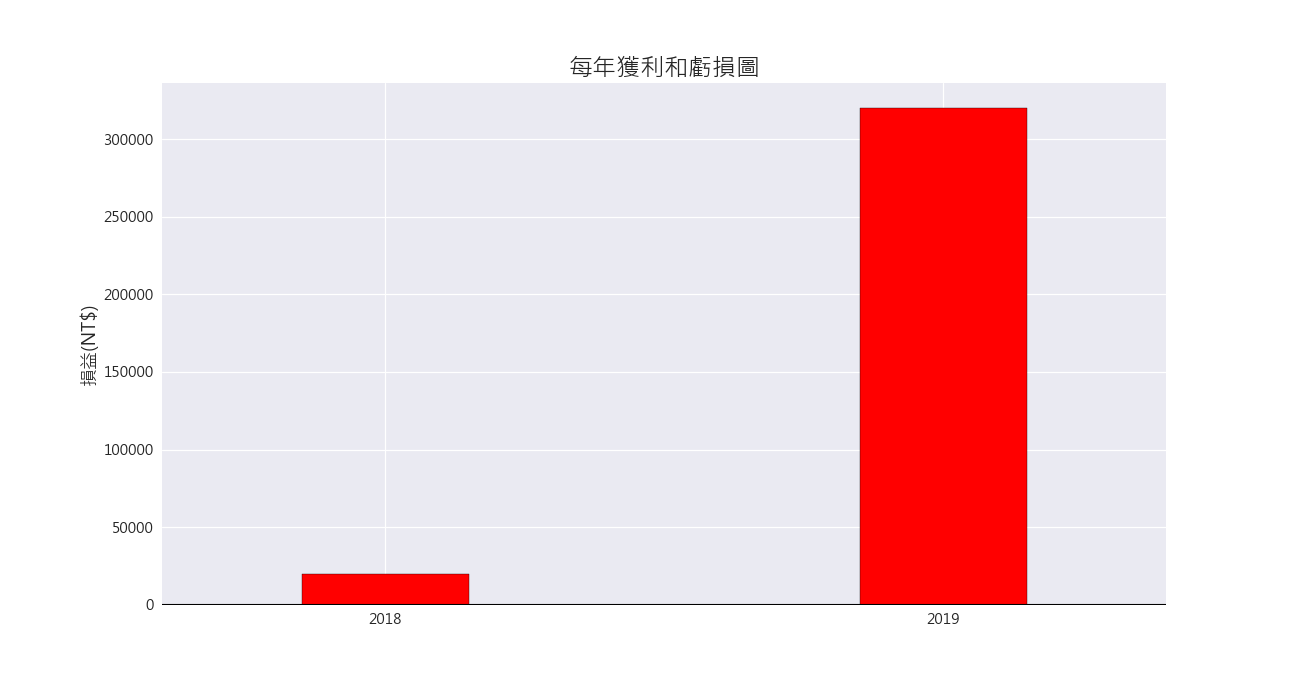

In [21]:
positive=yearly_pnl>0

fig,ax=plt.subplots(1,figsize=(15,8))
yearly_pnl.plot(kind='bar',color=positive.map({True:'r',False:'g'}),edgecolor='k',width=0.3,ax=ax)
ax.axhline(y=0,color='k',linestyle='-')
ax.set_title('每年獲利和虧損圖',fontsize=20)
ax.set_xlabel(None)
ax.set_ylabel('損益(NT$)',fontsize=15)
ax.tick_params(axis='y',labelsize=12)
ax.tick_params(axis='x',labelsize=12,rotation=0)

# 月週期分析表

In [22]:
month_idx=pd.date_range(d1,d2,freq='MS').to_period('M')
monthly_pnl=pnl_df.groupby(['年月'])['淨損益'].sum()
monthly_pnl=monthly_pnl.reindex(month_idx,fill_value=0)
monthly_pnl_rate=monthly_pnl/startcash*100

monthly_gross_profit=pnl_df.groupby(['年月'])['淨損益'].apply(sum_positive_series)
monthly_gross_profit=monthly_gross_profit.reindex(month_idx,fill_value=0)
monthly_gross_loss=monthly_pnl-monthly_gross_profit

monthly_trade_num=pnl_df.groupby(['年月'])['淨損益'].count()*2
monthly_trade_num=monthly_trade_num.reindex(month_idx,fill_value=0)
monthly_win_trade_num=pnl_df.groupby(['年月'])['淨損益'].apply(count_positive_series)*2
monthly_win_trade_num=monthly_win_trade_num.reindex(month_idx,fill_value=0)
monthly_win_rate=(monthly_win_trade_num/monthly_trade_num)*100

monthly_trade_df=pd.DataFrame({'獲利金額':monthly_pnl.apply(lambda x:'{:.2f}'.format(x)),
                               '獲利 (%)':monthly_pnl_rate.apply(lambda x:'{:.2f}%'.format(x) if not np.isnan(x) else x),
                               '毛利':monthly_gross_profit.apply(lambda x:'{:.2f}'.format(x)),
                               '毛損':monthly_gross_loss.apply(lambda x:'{:.2f}'.format(x)),
                               '交易次數':monthly_trade_num,
                               '勝率 (%)':monthly_win_rate.apply(lambda x:'{:.2f}%'.format(x) if not np.isnan(x) else x)})
monthly_trade_df

,獲利金額,獲利 (%),毛利,毛損,交易次數,勝率 (%)
2018-01,0.00,0.00%,0.00,0.00,0,NaN
2018-02,0.00,0.00%,0.00,0.00,0,NaN
2018-03,19921.29,0.20%,19921.29,0.00,2,100.00%
2018-04,0.00,0.00%,0.00,0.00,0,NaN
2018-05,0.00,0.00%,0.00,0.00,0,NaN
2018-06,0.00,0.00%,0.00,0.00,0,NaN
2018-07,0.00,0.00%,0.00,0.00,0,NaN
2018-08,0.00,0.00%,0.00,0.00,0,NaN
2018-09,0.00,0.00%,0.00,0.00,0,NaN
2018-10,0.00,0.00%,0.00,0.00,0,NaN


# 每月獲利和虧損圖

<IPython.core.display.Javascript object>


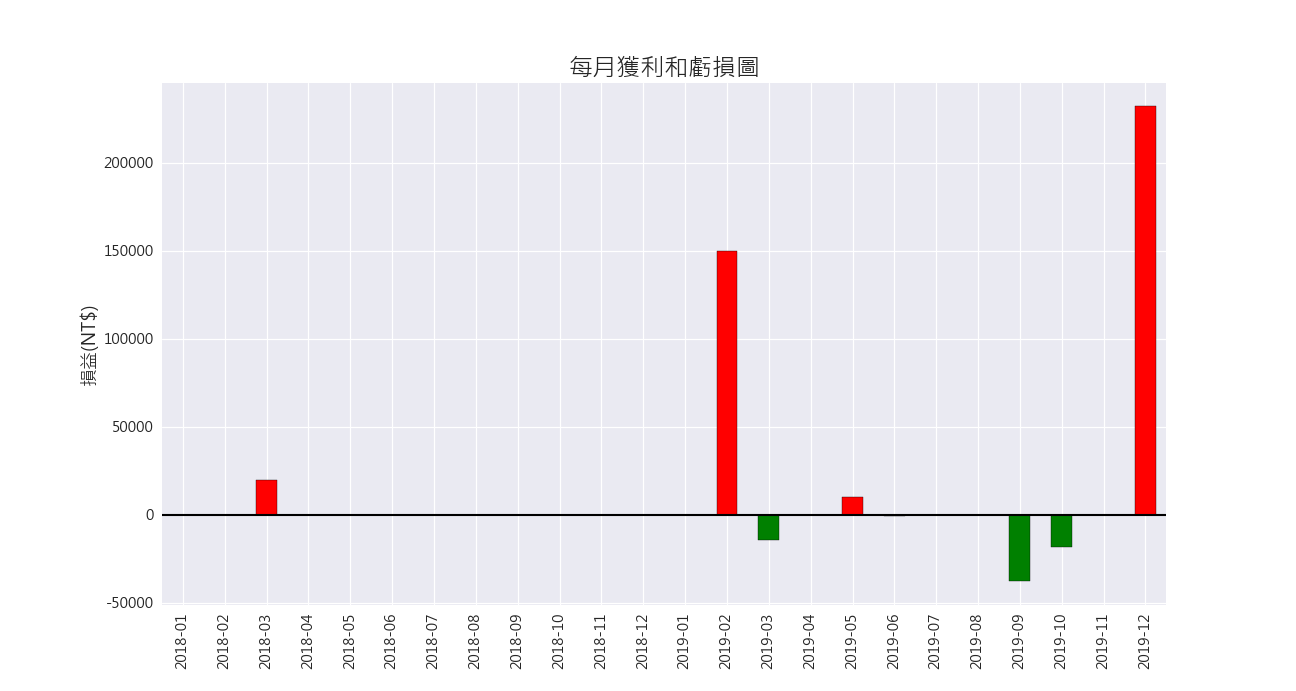

In [23]:
positive=monthly_pnl>0

fig,ax=plt.subplots(1,figsize=(15,8))
monthly_pnl.plot(kind='bar',color=positive.map({True:'r',False:'g'}),edgecolor='k',ax=ax)
ax.axhline(y=0,color='k',linestyle='-')
ax.set_title('每月獲利和虧損圖',fontsize=20)
ax.set_xlabel(None)
ax.set_ylabel('損益(NT$)',fontsize=15)
ax.tick_params(axis='y',labelsize=12)
ax.tick_params(axis='x',labelsize=12,rotation=90)

# 策略績效總結果表

In [24]:
total_adjust_gross_profit=adjust_gross_profit(TradeAnalyzer_information['won']['pnl']['total']*mult,TradeAnalyzer_information['won']['total']*2)
total_adjust_gross_loss=adjust_gross_loss(TradeAnalyzer_information['lost']['pnl']['total']*mult,TradeAnalyzer_information['total']['total']*2)
long_adjust_gross_profit=adjust_gross_profit(TradeAnalyzer_information['long']['pnl']['won']['total']*mult,TradeAnalyzer_information['long']['won']*2)
long_adjust_gross_loss=adjust_gross_loss(TradeAnalyzer_information['long']['pnl']['lost']['total']*mult,TradeAnalyzer_information['long']['total']*2)
short_adjust_gross_profit=adjust_gross_profit(TradeAnalyzer_information['short']['pnl']['won']['total']*mult,TradeAnalyzer_information['short']['won']*2)
short_adjust_gross_loss=adjust_gross_loss(TradeAnalyzer_information['short']['pnl']['lost']['total']*mult,TradeAnalyzer_information['short']['total']*2)


total_performance=[round(TradeAnalyzer_information['pnl']['net']['total']*mult,2),
                   round(TradeAnalyzer_information['won']['pnl']['total']*mult,2),
                   round(TradeAnalyzer_information['lost']['pnl']['total']*mult,2),
                   total_adjust_gross_profit+total_adjust_gross_loss,
                   total_adjust_gross_profit,
                   total_adjust_gross_loss,
                   ratio(TradeAnalyzer_information['won']['pnl']['total'],-TradeAnalyzer_information['lost']['pnl']['total']),
                   ratio(total_adjust_gross_profit,-total_adjust_gross_loss),
                   round(trade_df['交易成本'].sum(),2),
                   round(trade_df['滑價'].sum(),2),
                   round(trade_df['交易稅'].sum(),2)]

long_performance=[round(TradeAnalyzer_information['long']['pnl']['total']*mult,2),
                  round(TradeAnalyzer_information['long']['pnl']['won']['total']*mult,2),
                  round(TradeAnalyzer_information['long']['pnl']['lost']['total']*mult,2),
                  long_adjust_gross_profit+long_adjust_gross_loss,
                  long_adjust_gross_profit,
                  long_adjust_gross_loss,
                  ratio(TradeAnalyzer_information['long']['pnl']['won']['total'],-TradeAnalyzer_information['long']['pnl']['lost']['total']),
                  ratio(long_adjust_gross_profit,-long_adjust_gross_loss),
                  round(long_trade_df['交易成本'].sum(),2),
                  round(long_trade_df['滑價'].sum(),2),
                  round(long_trade_df['交易稅'].sum(),2)]

short_performance=[round(TradeAnalyzer_information['short']['pnl']['total']*mult,2),
                   round(TradeAnalyzer_information['short']['pnl']['won']['total']*mult,2),
                   round(TradeAnalyzer_information['short']['pnl']['lost']['total']*mult,2),
                   short_adjust_gross_profit+short_adjust_gross_loss,
                   short_adjust_gross_profit,
                   short_adjust_gross_loss,
                   ratio(TradeAnalyzer_information['short']['pnl']['won']['total'],-TradeAnalyzer_information['short']['pnl']['lost']['total']),
                   ratio(short_adjust_gross_profit,-short_adjust_gross_loss),
                   round(short_trade_df['交易成本'].sum(),2),
                   round(short_trade_df['滑價'].sum(),2),
                   round(short_trade_df['交易稅'].sum(),2)]

total_performance_df=pd.DataFrame({'所有交易':total_performance,
                                   '多單':long_performance,
                                   '空單':short_performance})

total_performance_df.index=['淨利','毛利','毛損','調整後淨利','調整後毛利','調整後毛損','獲利因子','調整後獲利因子',
                            '交易成本支付','滑價支付','交易稅支付']
total_performance_df

,所有交易,多單,空單
淨利,340398.27,241326.05,99072.22
毛利,411948.07,242212.04,169736.03
毛損,-71549.80,-885.99,-70663.81
調整後淨利,699423.51,476937.92,-590624.61
調整後毛利,2130419.45,484424.07,339472.06
調整後毛損,-1430995.94,-7486.15,-930096.67
獲利因子,5.76,273.38,2.40
調整後獲利因子,1.49,64.71,0.36
交易成本支付,3887.73,1459.95,2427.78
滑價支付,3200.00,1200.00,2000.00


# 總交易分析表

In [25]:
total_trade=[int(TradeAnalyzer_information['total']['total']*2),
             int(TradeAnalyzer_information['won']['total']*2),
             int(TradeAnalyzer_information['lost']['total']*2),
             percentage(TradeAnalyzer_information['won']['total'],TradeAnalyzer_information['total']['total']),
             round(TradeAnalyzer_information['pnl']['net']['average']*mult,2),
             round(TradeAnalyzer_information['won']['pnl']['average']*mult,2),
             round(TradeAnalyzer_information['lost']['pnl']['average']*mult,2),
             ratio(TradeAnalyzer_information['won']['pnl']['average'],-TradeAnalyzer_information['lost']['pnl']['average']),
             round(TradeAnalyzer_information['won']['pnl']['max']*mult,2),
             round(TradeAnalyzer_information['lost']['pnl']['max']*mult,2),
             round(TradeAnalyzer_information['len']['average'],1),
             round(TradeAnalyzer_information['len']['won']['average'],1),
             round(TradeAnalyzer_information['len']['lost']['average'],1)]

long_trade=[int(TradeAnalyzer_information['long']['total']*2),
            int(TradeAnalyzer_information['long']['won']*2),
            int(TradeAnalyzer_information['long']['lost']*2),
            percentage(TradeAnalyzer_information['long']['won'],TradeAnalyzer_information['long']['total']),
            round(TradeAnalyzer_information['long']['pnl']['average']*mult,2),
            round(TradeAnalyzer_information['long']['pnl']['won']['average']*mult,2),
            round(TradeAnalyzer_information['long']['pnl']['lost']['average']*mult,2),
            ratio(TradeAnalyzer_information['long']['pnl']['won']['average'],-TradeAnalyzer_information['long']['pnl']['lost']['average']),
            round(TradeAnalyzer_information['long']['pnl']['won']['max']*mult,2),
            round(TradeAnalyzer_information['long']['pnl']['lost']['max']*mult,2),
            round(TradeAnalyzer_information['len']['long']['average'],1),
            round(TradeAnalyzer_information['len']['long']['won']['average'],1),
            round(TradeAnalyzer_information['len']['long']['lost']['average'],1)]

short_trade=[int(TradeAnalyzer_information['short']['total']*2),
             int(TradeAnalyzer_information['short']['won']*2),
             int(TradeAnalyzer_information['short']['lost']*2),
             percentage(TradeAnalyzer_information['short']['won'],TradeAnalyzer_information['short']['total']),
             round(TradeAnalyzer_information['short']['pnl']['average']*mult,2),
             round(TradeAnalyzer_information['short']['pnl']['won']['average']*mult,2),
             round(TradeAnalyzer_information['short']['pnl']['lost']['average']*mult,2),
             ratio(TradeAnalyzer_information['short']['pnl']['won']['average'],-TradeAnalyzer_information['short']['pnl']['lost']['average']),
             round(TradeAnalyzer_information['short']['pnl']['won']['max']*mult,2),
             round(TradeAnalyzer_information['short']['pnl']['lost']['max']*mult,2),
             round(TradeAnalyzer_information['len']['short']['average'],1),
             round(TradeAnalyzer_information['len']['short']['won']['average'],1),
             round(TradeAnalyzer_information['len']['short']['lost']['average'],1)]

total_trade_df=pd.DataFrame({'所有交易':total_trade,
                             '多單':long_trade,
                             '空單':short_trade})

total_trade_df.index=['交易總次數','獲利交易次數','虧損交易次數','勝率','平均交易(獲利 虧損)','平均獲利交易',
                      '平均虧損交易','平均獲利/平均虧損 比率','最大的交易獲利','最大的交易虧損','平倉交易的平均K棒數',
                      '獲利平倉交易的平均K棒數','虧損平倉交易的平均K棒數']
total_trade_df

,所有交易,多單,空單
交易總次數,16,6,10
獲利交易次數,8,4,4
虧損交易次數,8,2,6
勝率,50.00%,66.67%,40.00%
平均交易(獲利 虧損),42549.8,80442,19814.4
平均獲利交易,102987,121106,84868
平均虧損交易,-17887.5,-885.99,-23554.6
平均獲利/平均虧損 比率,5.76,136.69,3.6
最大的交易獲利,232022,232022,149815
最大的交易虧損,-37610.5,-885.99,-37610.5


In [26]:
summary_list=['{} ~ {}'.format(d1,d2),
              total_day_num,
              '{:.2f}'.format(startcash),
              '{:.2f}'.format(startcash+TradeAnalyzer_information['pnl']['net']['total']*mult),
              '{:.2f}'.format(TradeAnalyzer_information['pnl']['gross']['total']*mult),
              '{:.2f}'.format(TradeAnalyzer_information['pnl']['net']['total']*mult),
              '{:.2f}'.format(TradeAnalyzer_information['pnl']['gross']['total']*mult-TradeAnalyzer_information['pnl']['net']['total']*mult),
              '{:.2f}'.format(TradeAnalyzer_information['pnl']['gross']['average']*mult),
              '{:.2f}'.format(TradeAnalyzer_information['pnl']['net']['average']*mult),
              '{:.2f}'.format(TradeAnalyzer_information['pnl']['gross']['average']*mult-TradeAnalyzer_information['pnl']['net']['average']*mult),
              '{:.4f}%'.format(TradeAnalyzer_information['pnl']['net']['total']*mult/startcash*100),
              '{:.4f}%'.format(daily_return_df['daily_return(%)'].mean()),
              '{:.4f}%'.format(((1+TradeAnalyzer_information['pnl']['net']['total']*mult/startcash)**(252/total_day_num)-1)*100),
              '{:.2f}'.format(DW_information['moneydown']*mult),
              '{:.4f}%'.format(DW_information['moneydown']*mult/startcash*100),
              DW_information['len'],
              '{:.2f}'.format(TradeAnalyzer_information['pnl']['net']['total']/DW_information['moneydown']),
              TradeAnalyzer_information['total']['total']*2,
              TradeAnalyzer_information['streak']['won']['longest'],
              TradeAnalyzer_information['streak']['lost']['longest']]


title_list=['回測期間','總天數','初始資金','期末資金','總交易毛損利','總交易净損利','交易稅和滑價','總交易平均毛損利','總交易平均淨損利',
            '平均交易稅和滑價','總報酬率(%)','總平均報酬率(%)','總年化報酬率(%)','MDD金額','MDD比率(%)','MDD回復天數','最大策略虧損報酬(風報比)',
            '總交易次數','最長連續獲利次數','最長連續虧損次數']

total_summary_df=pd.DataFrame([summary_list],columns=title_list).T
total_summary_df.columns=['績效概述']
total_summary_df

,績效概述
回測期間,2018-01-01 ~ 2019-12-31
總天數,729
初始資金,10000000.00
期末資金,10340398.27
總交易毛損利,344286.00
總交易净損利,340398.27
交易稅和滑價,3887.73
總交易平均毛損利,43035.75
總交易平均淨損利,42549.78
平均交易稅和滑價,485.97
